In [15]:
import keras
keras.__version__



In [60]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

img_path = '/Users/xinqunye/Desktop/2020spring/deep_learning/lab/elephant.png'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#x = preprocess_input(x)
img_tensor /= 255

#preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
#print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/xinqunye/Desktop/2020spring/deep_learning/lab/elephant.png'

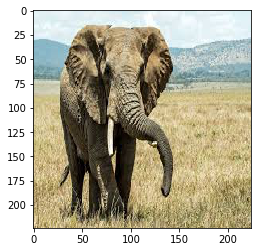

In [45]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [46]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [47]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 224, 224, 3)


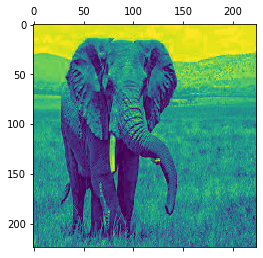

In [48]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
plt.show()

In [52]:
model.layers[:8]

/Users/xinqunye/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

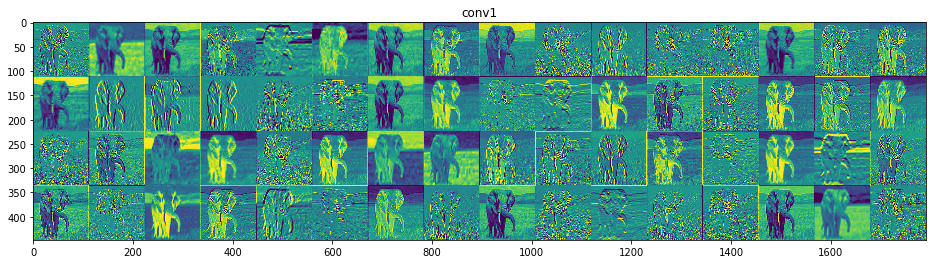

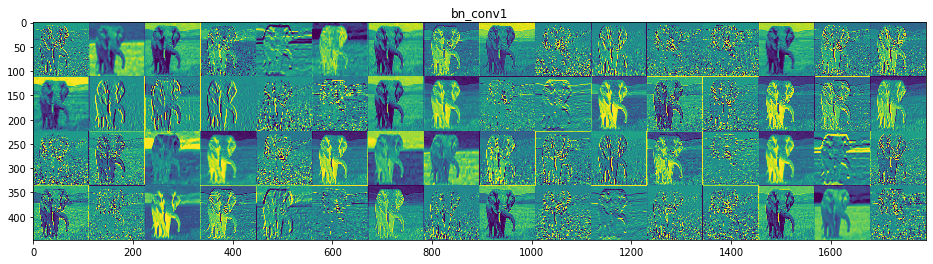

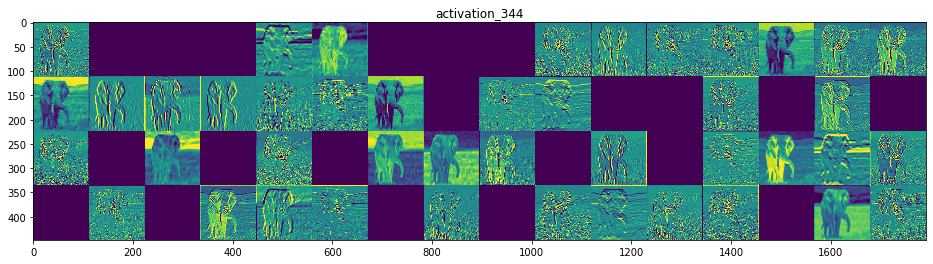

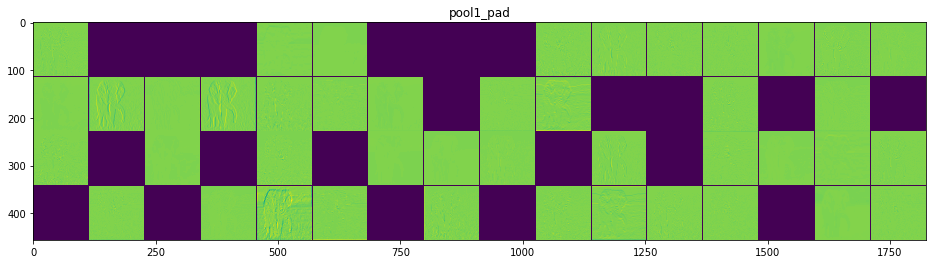

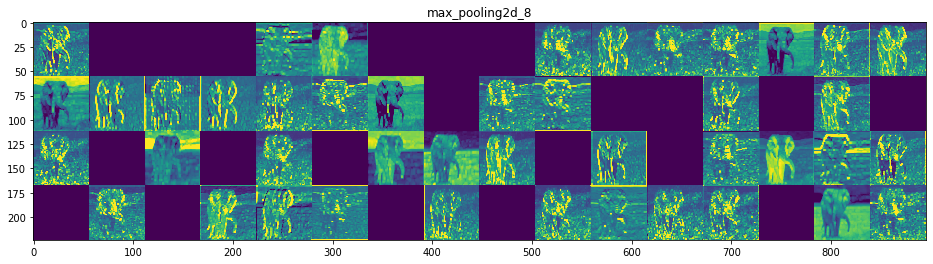

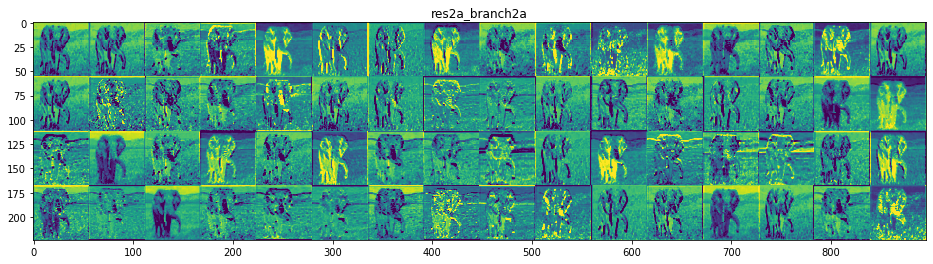

In [51]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [53]:
from keras.applications import VGG16
from keras import backend as K

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

# Selecting a layer and channel to visualize
layer_name = 'block3_conv1'
filter_index = 0
 
# Isolate the output and loss for the given chanel
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# We take the gradient of this loss using keras backend.gradients
grads = K.gradients(loss, model.input)[0]

# Before performing gradient descent, we divide the gradient tensor by its L2 norm (square root
# of the mean of the square of values in the tensor). We add a small epsilon term to the L2 norm
# to avoid division by zero.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# We use a keras backend function to accept a numpy tensor and return a loss and gradient for that tensor.
iterate = K.function([model.input], [loss, grads])

# To quickly test the interface:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

58892288/58889256 [==============================] - 21s 0us/step


In [54]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [55]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

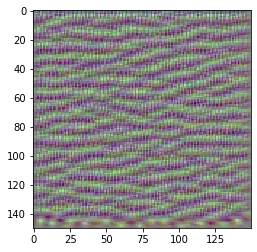

In [58]:
plt.imshow(generate_pattern('block3_conv1', 7))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


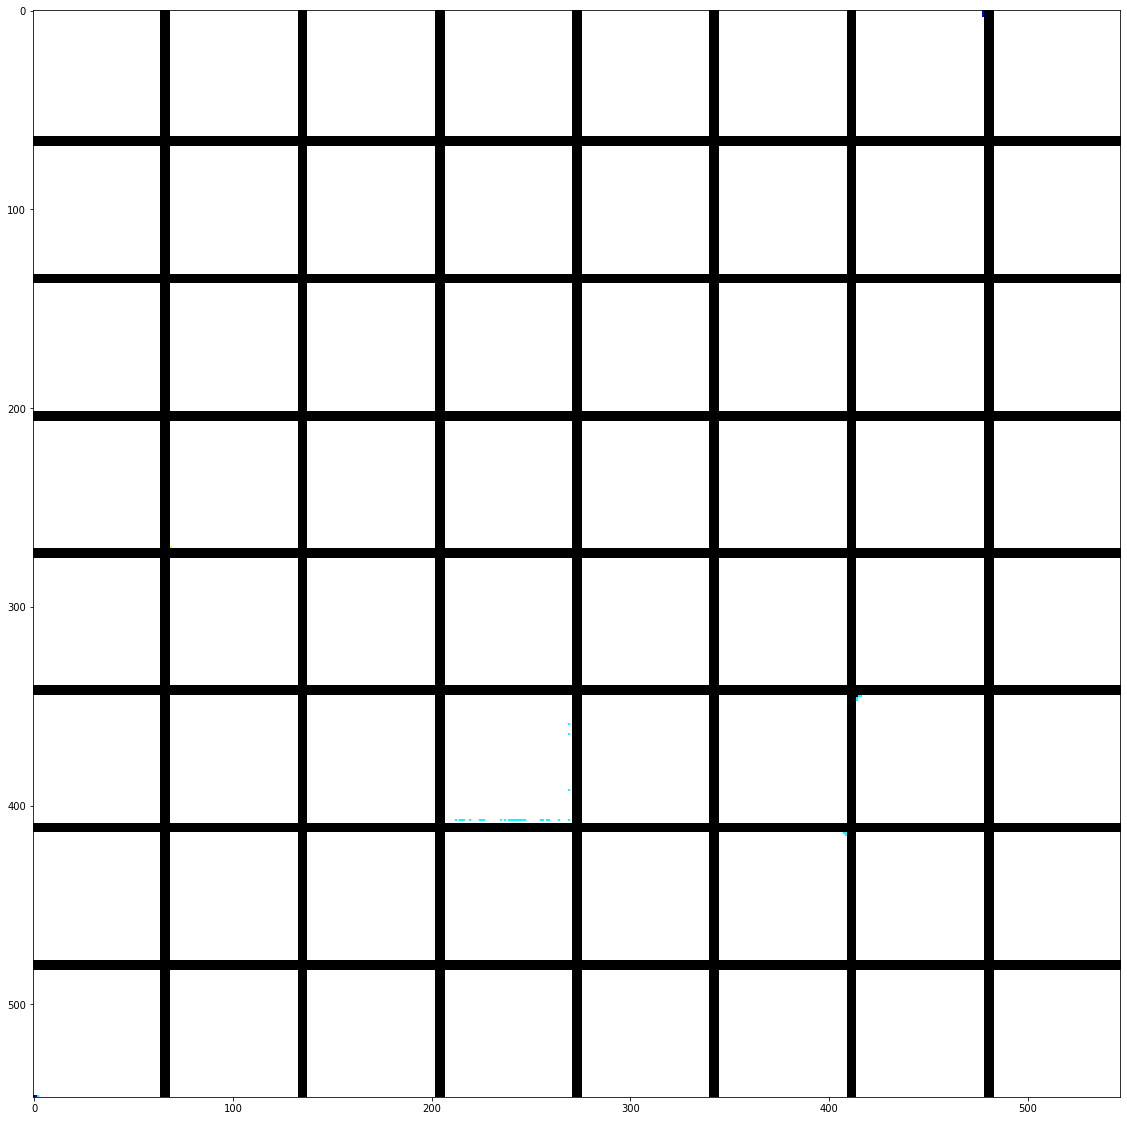

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


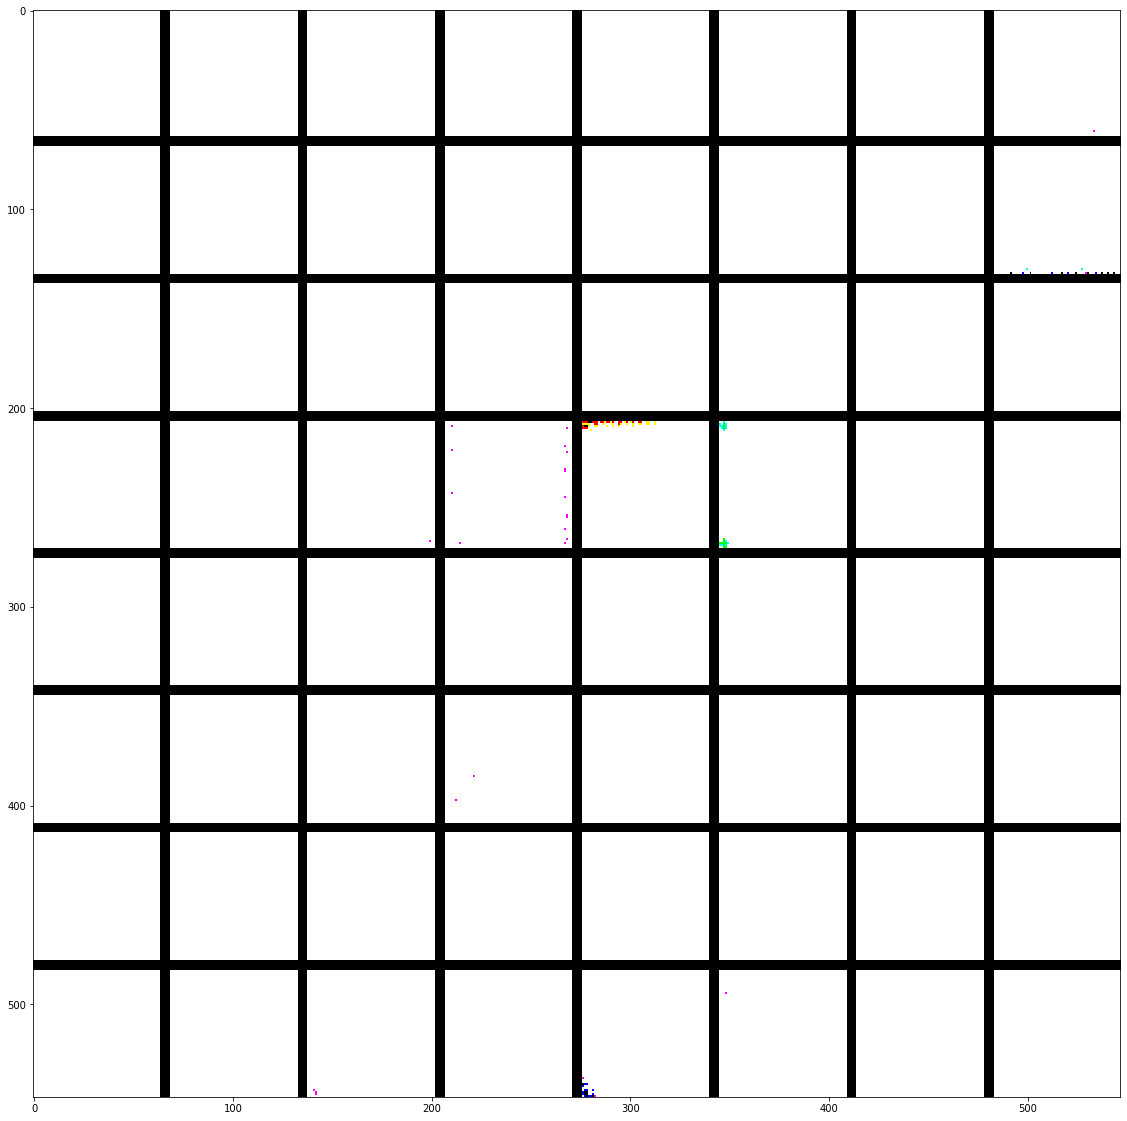

In [59]:
for layer_name in ['block1_conv1', 'block2_conv1']: #, 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()